# Thrombolysis prediction shap

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from xgboost import XGBClassifier

## Load data

In [2]:
data = pd.read_csv('../data/thrombolysis_xgb_data_2017_2019.csv')

In [3]:
data.head()

,stroke team,age,infarction,stroke severity,onset-to-arrival time,precise onset known,onset during sleep,use of AF anticoagulants,prior disability,arrival-to-scan time,thrombolysis
0,Peterborough City Hospital,52.5,1,2,78,1,0,0,0,87.0,0
1,Royal Hampshire County Hospital,57.5,1,7,96,0,1,0,0,58.0,0
2,Basildon University Hospital,67.5,1,2,164,1,0,0,0,18.0,0
3,Withybush General Hospital,62.5,1,5,150,0,0,0,0,48.0,1
4,Fairfield General Hospital,87.5,1,2,65,1,0,0,4,7.0,0


## Split data into X and y

In [4]:
X = data.drop(['thrombolysis'], axis=1)
y = data['thrombolysis']

## Fit XGBoost model

In [5]:
# One hot encode hospitals
X_train_hosp = (pd.get_dummies(X['stroke team'], prefix='team'))
X_train = pd.concat([X, X_train_hosp], axis=1)
X_train.drop('stroke team', axis=1, inplace=True)

# Create XGBoost model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
model.fit(X_train, y)

# Get predictions
y_pred = model.predict(X_train)
y_pred_proba = model.predict_proba(X_train)[:, 1]
accuracy = np.mean(y_pred == y)
print(f'\nAccuracy: {accuracy:.3f}')


Accuracy: 0.886


## Get SHAP values

In [6]:
# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model, X_train)

# GetShapley values along with base and feature values
shap_values_extended = explainer(X_train)
shap_values = shap_values_extended.values

100%|===================| 69376/69510 [01:10<00:00]        

## Summary SHAP plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


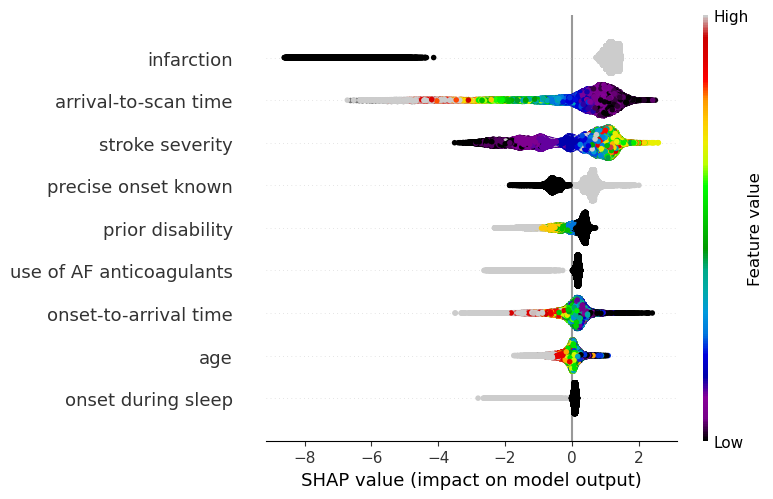

In [7]:
shap.summary_plot(
    shap_values=shap_values,
    features=X_train,
    max_display=9,
    cmap=plt.get_cmap('nipy_spectral'), show=False)


## Get hospital SHAP

In [8]:
# Get list of stroke teams
stroke_teams = X['stroke team'].unique()
stroke_teams.sort()

# Get mean SHAP for stroke team when patient attending that stroke team
stroke_team_mean_shap = dict()
# Loop through stroke teams
for stroke_team in stroke_teams:
    # Identify rows in test data that match each stroke team
    mask = X['stroke team'] == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = 'team_' + stroke_team
    index = list(X_train).index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Store median SHAP value for stroke team
    stroke_team_mean_shap[stroke_team] = np.median(stroke_team_shap)

In [9]:
stroke_team_shap_df = pd.DataFrame.from_dict(
    stroke_team_mean_shap, orient='index', columns=['shap'])

stroke_team_shap_df['odds_ratio'] = np.exp(stroke_team_shap_df['shap'])

In [10]:
stroke_team_shap_df

,shap,odds_ratio
Addenbrooke's Hospital,0.526567,1.693109
Basildon University Hospital,0.240941,1.272446
Blackpool Victoria Hospital,-0.353723,0.702070
Bradford and Airedale SU,-0.235998,0.789783
Broomfield Hospital,-0.204034,0.815435
...,...,...
Worthing Hospital,0.406333,1.501303
Wycombe General Hospital,0.292859,1.340254
Yeovil District Hospital,0.392428,1.480571
York Hospital,-0.247052,0.781100


Add observed thrombolysis

In [11]:
observed_thrombolysis = data.groupby('stroke team')['thrombolysis'].mean()

In [12]:
stroke_team_shap_df['observed thrombolysis (%)'] = observed_thrombolysis * 100
# Sort by SHAP
stroke_team_shap_df.sort_values(by='shap', ascending=False, inplace=True)
stroke_team_shap_df = stroke_team_shap_df.round(3)

# Display all rows
pd.options.display.max_rows = 200
stroke_team_shap_df

,shap,odds_ratio,observed thrombolysis (%)
Southend Hospital,1.049,2.855,35.674
Morriston Hospital,1.038,2.825,41.831
Watford General Hospital,1.024,2.785,37.821
Queens Hospital Romford HASU,0.948,2.581,43.380
Royal London Hospital HASU,0.802,2.231,48.807
Luton and Dunstable Hospital,0.798,2.220,35.948
University College Hospital HASU,0.732,2.079,34.890
Royal Berkshire Hospital,0.715,2.044,46.414
Charing Cross Hospital HASU,0.665,1.945,39.015
Queen Alexandra Hospital Portsmouth,0.663,1.941,33.076


Save results.

In [13]:
stroke_team_shap_df.to_csv('./output/stroke_team_shap.csv')

Plot histogram of hospital shap

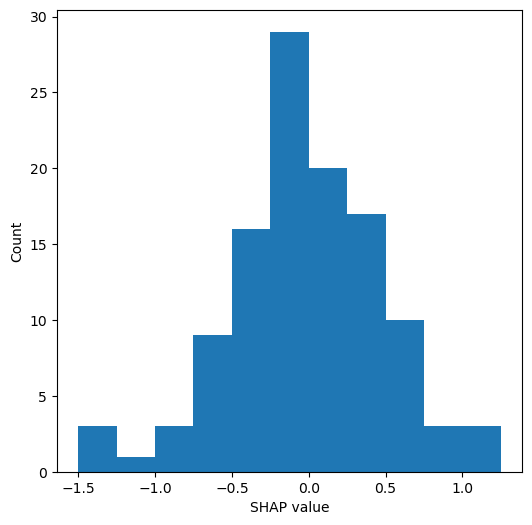

In [14]:
# Plot histogram
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(stroke_team_shap_df['shap'], bins=np.arange(-1.5, 1.31, 0.25))
ax.set_xlabel('SHAP value')
ax.set_ylabel('Count')
plt.show()

To do: get main effect

In [15]:
#Get SHAP interaction values
#explainer = shap.TreeExplainer(model)
#shap_interaction = explainer.shap_interaction_values(X_train)